Movie Recommender

In this project we will be building a Movie Recommender system using collaboratibve filtering

## Importing Packages 

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
#Loading dataset
movies = pd.read_csv("ml-latest-small/ml-latest-small/movies.csv")
ratings =  pd.read_csv("ml-latest-small/ml-latest-small/ratings.csv")



In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
#Number of ratings, movies and users we have in our data set 
total_ratings =len(ratings)
total_movies=ratings['movieId'].nunique()
total_users =ratings['userId'].nunique()

print(f"Total ratings{total_ratings}")
print(f"Total movies{total_movies}")
print(f"Total users{total_users}")


Total ratings100836
Total movies9724
Total users610


### Data Exploration

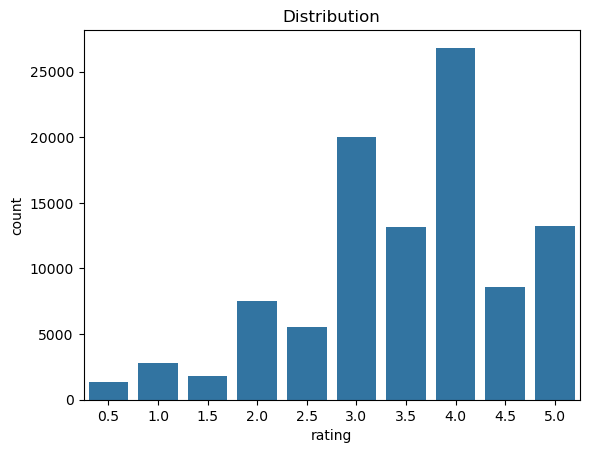

In [9]:
sns.countplot(x='rating',data=ratings)
plt.title('Distribution')
plt.show()

In [16]:
#The top 5 rated movies
movie_ratings = ratings.merge(movies, on='movieId')
top_movies = movie_ratings['title'].value_counts().nlargest(5)
print(top_movies)

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: count, dtype: int64


In [18]:
#The last 5 rated movies
lowest_movies = movie_ratings['title'].value_counts().nsmallest(5)
print(lowest_movies)

title
Julia (2014)                  1
You Only Live Once (1937)     1
Music Box (1989)              1
Getaway (2013)                1
Ricki and the Flash (2015)    1
Name: count, dtype: int64
